In [29]:
%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_create
from pathlib import Path
import exposures as ex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
#choose country
country = 882

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
lower_share = 0.045
upper_rp = 250

target_sharpe = 0.5
rf_rate = 0.0

cc_models = ["CMCC", "CNRM", "ECEARTH", "HADGEM"]

OUTPUR_DIR = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/hazard")
STORM_DIR = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/hazard/tc_tracks/storm_tc_tracks/climate_change")

In [31]:
bond_metrics_dic = {}
bond_returns_dic = {}
premium_dic_dic = {}
nominal_dic = {}
pay_dam_df_dic = {}
es_metrics_dic = {}
int_grid_dic = {}
imp_per_event_flt_dic = {}
imp_admin_evt_flt_dic = {}

bond_metrics_dic['cur_cl'], bond_returns_dic['cur_cl'], premium_dic_dic['cur_cl'], nominal_dic['cur_cl'], pay_dam_df_dic['cur_cl'], es_metrics_dic['cur_cl'], int_grid_dic['cur_cl'], imp_per_event_flt_dic['cur_cl'], imp_admin_evt_flt_dic['cur_cl'] = bond_create.sng_cty_bond(country, prot_share=upper_rp, to_prot_share=lower_share)

for mod in cc_models:
    bond_metrics, bond_returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt = bond_create.sng_cty_bond_cc(country, cc_model=mod, prot_share=0.289, to_prot_share=lower_share, output_dir=OUTPUR_DIR, storm_dir=STORM_DIR)

    bond_metrics_dic[mod] = bond_metrics
    bond_returns_dic[mod] = bond_returns
    premium_dic_dic[mod] = premium_dic
    nominal_dic[mod] = nominal
    pay_dam_df_dic[mod] = pay_dam_df
    es_metrics_dic[mod] = es_metrics
    int_grid_dic[mod] = int_grid
    imp_per_event_flt_dic[mod] = imp_per_event_flt
    imp_admin_evt_flt_dic[mod] = imp_admin_evt_flt


Number of tracks in SP basin: 713
The principal of the cat bond is: 251308348.279 [USD]
Principal as share of GDP: 0.289
Number of tracks in SP basin: 2708
The principal of the cat bond is: 251111625.539 [USD]
Principal as share of GDP: 0.289
Number of tracks in SP basin: 4133
The principal of the cat bond is: 251111625.539 [USD]
Principal as share of GDP: 0.289
Number of tracks in SP basin: 3188
The principal of the cat bond is: 251111625.539 [USD]
Principal as share of GDP: 0.289
Number of tracks in SP basin: 2718
The principal of the cat bond is: 251111625.539 [USD]
Principal as share of GDP: 0.289


<Axes: xlabel='Climate Condition', ylabel='Premium [USD]'>

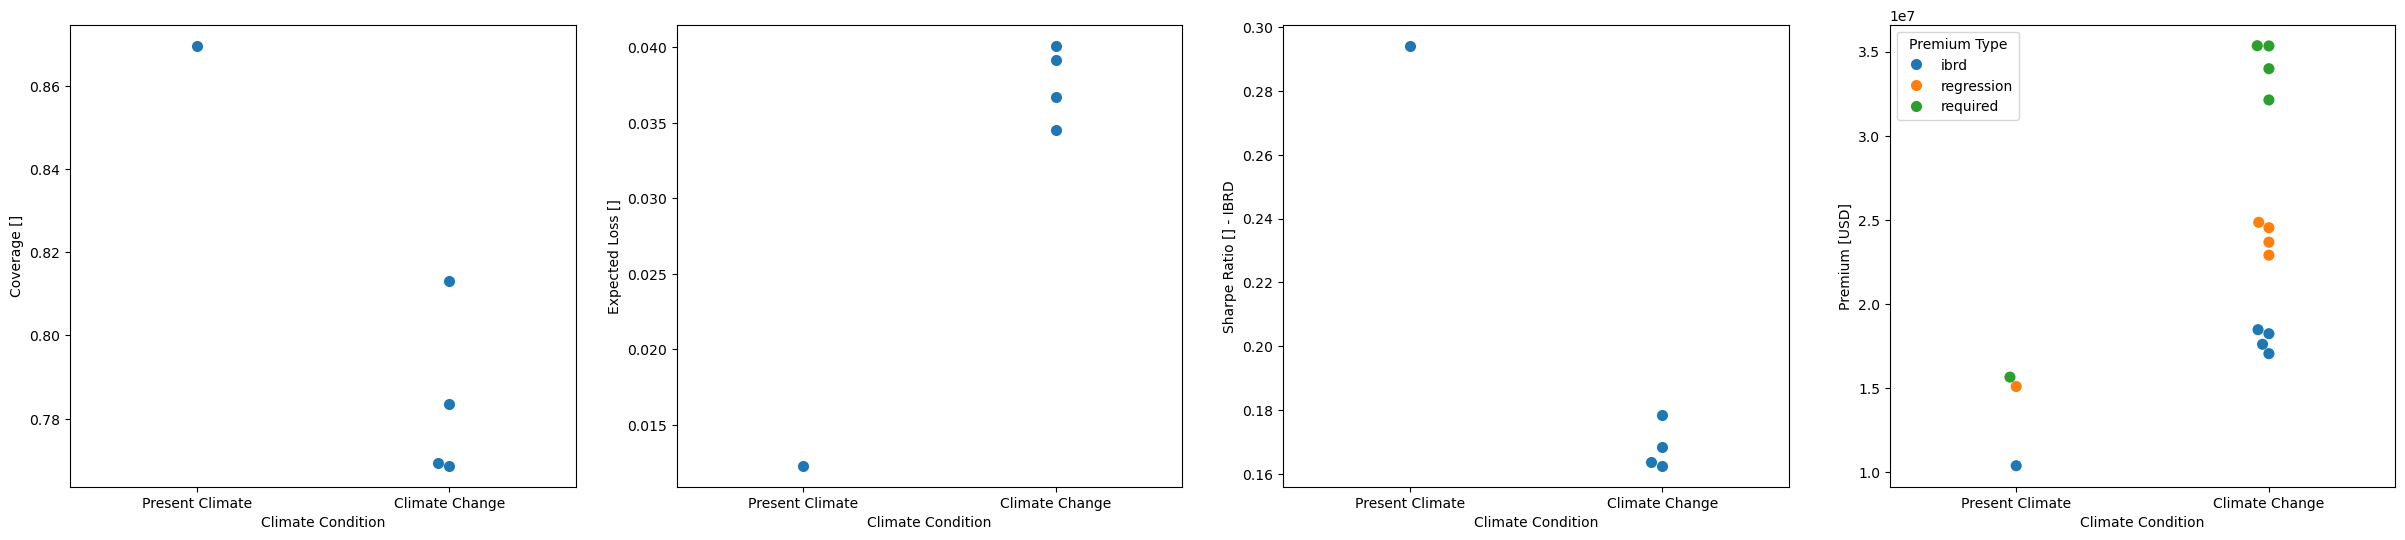

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
tc_sets = ["cur_cl", "CMCC", "CNRM", "ECEARTH", "HADGEM"]
cc_cond = ["Present Climate", "Climate Change", "Climate Change", "Climate Change", "Climate Change"]

cc_coverage = []
prem_data = []
cc_exp_loss = []
cc_sharpe = []
for i, mod in enumerate(tc_sets):
    cc_coverage.append(bond_metrics_dic[mod]['Coverage'])
    cc_exp_loss.append(premium_dic_dic[mod]['exp_loss'])
    cc_sharpe.append(bond_metrics_dic[mod]['Sharpe_ratio_ann'])
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "ibrd", "Premium [USD]": premium_dic_dic[mod]['ibrd'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "regression", "Premium [USD]": premium_dic_dic[mod]['regression'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "required", "Premium [USD]": premium_dic_dic[mod]['required'] * nominal_dic[mod]})

cc_coverage = np.array(cc_coverage).flatten()
cc_exp_loss = np.array(cc_exp_loss).flatten()
cc_sharpe = np.array(cc_sharpe).flatten()
prem_data = pd.DataFrame(prem_data)

df_coverage = {'Coverage []': cc_coverage, 'Climate Condition': cc_cond}
df_exp_loss = {'Expected Loss []': cc_exp_loss, 'Climate Condition': cc_cond}
df_sharpe = {'Sharpe Ratio [] - IBRD': cc_sharpe, 'Climate Condition': cc_cond}

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 6))

sns.swarmplot(y='Coverage []', x='Climate Condition', data=df_coverage, size=8, ax=ax1)
sns.swarmplot(y='Expected Loss []', x='Climate Condition', data=df_exp_loss, size=8, ax=ax2)
sns.swarmplot(y='Sharpe Ratio [] - IBRD', x='Climate Condition', data=df_sharpe, size=8, ax=ax3)
sns.swarmplot(y='Premium [USD]', x='Climate Condition', data=prem_data, size=8, ax=ax4, hue='Premium Type')

